# Vancouver Airbnb Price Prediction

TODO:
- cross-validation for models
- optimize hyperparameters
- how to interpret validation error
- add "word" features that help predict prices
- Scatterplot of data to visually see if there are any obvious correlations
- take combined training and validation set and have my best model be trained on that, then test it using the test set once (check if the test error and validation error agree)
- histogram of number of beds, ___ etc per user
- Make a plot of training/validation error vs. regularization strength for some model
- conclusion

In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

%matplotlib inline

In [68]:
# Read in excel file data
df = pd.read_csv('data/vancouver_listings_full.csv')

In [69]:
print(df.shape)

print(df.columns.tolist())

(6651, 96)
['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthl

We start off with 6651 observations (ie. listings) and 96 features for each of the listings.

### Data Cleaning (Remove Unnecessary Symbols)

In [78]:
# Remove the dollar signs in the 'extra_people' column
df['extra_people'] = df['extra_people'].astype(str)
df['extra_people'] = df['extra_people'].str.replace('$', '')
df['extra_people'] = df['extra_people'].astype(float)

# Remove the dollar signs and commas in the 'price' column
df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float)

# Remove the dollar signs and commas in the 'security_deposit' column
df['security_deposit'] = df['security_deposit'].astype(str)
df['security_deposit'] = df['security_deposit'].str.replace('$', '')
df['security_deposit'] = df['security_deposit'].str.replace(',', '')
df['security_deposit'] = df['security_deposit'].astype(float)

# Remove the dollar signs in the 'cleaning_fee' column
df['cleaning_fee'] = df['cleaning_fee'].astype(str)
df['cleaning_fee'] = df['cleaning_fee'].str.replace('$', '')
df['cleaning_fee'] = df['cleaning_fee'].astype(float)

<class 'pandas.core.series.Series'>


### Data Cleaning (Replace NaN Values)

In [79]:
# Replace all the NaN values in "review_scores_rating" with the mean value
mean_review_scores_rating = np.nanmean(df["review_scores_rating"])
df["review_scores_rating"].fillna(value=mean_review_scores_rating, inplace=True)

# Replace all the NaN values in "bathrooms" to the mean value
mean_bathrooms = np.nanmean(df["bathrooms"])
df["bathrooms"].fillna(value=mean_bathrooms, inplace=True)

# Replace all the NaN values in "bedrooms" to the mean value
mean_bedrooms = np.nanmean(df["bedrooms"])
df["bedrooms"].fillna(value=mean_bedrooms, inplace=True)

# Replace all the NaN values in "beds" to the mean"
mean_beds = np.nanmean(df["beds"])
df["beds"].fillna(value=mean_beds, inplace=True)

# Replace all the NaN values in "security_deposit" with the mean
mean_security_deposit = np.nanmean(df["security_deposit"])
df["security_deposit"].fillna(value=mean_security_deposit, inplace=True)

# Replace all the NaN values in "cleaning_fee" with the mean
mean_cleaning_fee = np.nanmean(df["cleaning_fee"])
df["cleaning_fee"].fillna(value=mean_cleaning_fee, inplace=True)

<class 'pandas.core.series.Series'>


## Summary Statistics and Visualizations

### Average Price for each Neighborhood

In [72]:
# Determine average price of an Airbnb
avg_price = np.mean(df["price"])

print(avg_price)

151.7997293640054


I found that the average price of an Airbnb in Vancouver is $151.80

### Maximum Listing Price

In [96]:
# Determine the most expensive Airbnb listing in Vancouver
max_price = np.max(df["price"])

print(max_price)

15000.0


I found the most expensive Airbnb listing in Vancouver is $15,000. This is most definitely an outlier.

### Maximum Listing Price

In [74]:
# Determine the cheapest Airbnb listing in Vancouver
min_price = np.min(df["price"])

print(min_price)

0.0


I found that the cheapest Airbnb listing in Vancouver is $0. This is an outlier for sure, probably shouldn't be included in the training of the model.

Average prices by neighborhood

Dunbar Southlands: $168
Renfrew-Collingwood: $91
Hastings-Sunrise: $137
Oakridge: $129
Downtown Eastside: $164
Kensington-Cedar Cottage: $114
Killarney: $74
Kerrisdale: $162
Sunset: $122
Marpole: $111
Kitsilano: $158
Victoria-Fraserview: $89
South Cambie: $158
West End: $169
Riley Park: $140
Shaughnessy: $157
West Point Grey: $154
Grandview-Woodland: $118
Arbutus Ridge: $175
Mount Pleasant: $137
Fairview: $175
Downtown: $192
Strathcona: $154


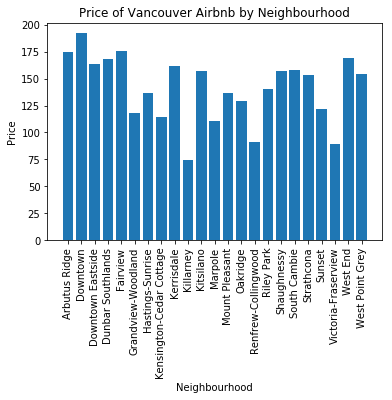

In [94]:
# Determine most expensive neighborhood on average
neighbourhoods = df['neighbourhood_cleansed'].unique()
avg_neigh_prices = np.zeros(len(neighbourhoods))

for neighbourhood in range(len(neighbourhoods)):
    list_of_neigh_price = df.loc[df['neighbourhood_cleansed'] == neighbourhoods[neighbourhood], 'price']
    avg_price_single_neigh = np.mean(list_of_neigh_price)
    avg_neigh_prices[neighbourhood] = avg_price_single_neigh
    
print("Average prices by neighborhood\n")

for i in range(len(neighbourhoods)):
    print(neighbourhoods[i] + ": ${:0.0f}".format(avg_neigh_prices[i]))
    
    
inds = neighbourhoods
fig, ax = plt.subplots()
rects = ax.bar(inds, avg_neigh_prices)
ax.set_xlabel("Neighbourhood")
ax.set_ylabel('Price')
ax.set_title('Price of Vancouver Airbnb by Neighbourhood')
plt.xticks(rotation='vertical')
plt.show()

Most expensive neighborhood for Airbnb's in Vancouver is: Downtown. We see that the top 3 most expensive neighborhoods to live in are Downtown, Arbutus Ridge, and Fairview.

Downtown                    1214
Kitsilano                    737
West End                     674
Mount Pleasant               582
Grandview-Woodland           443
Kensington-Cedar Cottage     407
Downtown Eastside            377
Riley Park                   324
Fairview                     305
Renfrew-Collingwood          266
Hastings-Sunrise             228
Dunbar Southlands            153
Marpole                      149
Sunset                       120
West Point Grey              104
South Cambie                  97
Oakridge                      89
Kerrisdale                    83
Victoria-Fraserview           70
Arbutus Ridge                 69
Shaughnessy                   68
Killarney                     64
Strathcona                    28
Name: neighbourhood_cleansed, dtype: int64


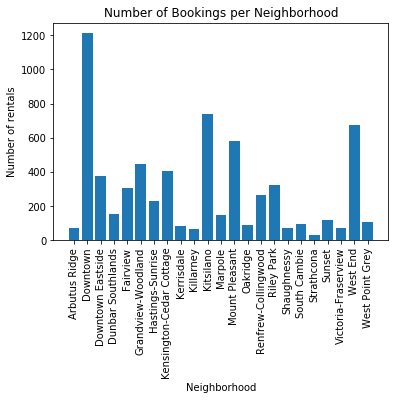

In [76]:
# Find the most common neighborhoods.
neighbourhoodCounts = df["neighbourhood_cleansed"].value_counts()

print(neighbourhoodCounts)

# Small workaround here since the indexing was weird in the provided data structure
neighbourhoods = np.asarray(neighbourhoodCounts.axes)[0]
counts = neighbourhoodCounts.values

fig, ax = plt.subplots()
rects = ax.bar(neighbourhoods, counts)
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Number of rentals")
ax.set_title("Number of Bookings per Neighborhood")
plt.xticks(rotation='vertical')
plt.show()

The 3 most popular areas to book in Vancouver are Downtown, Kitsilano, and West End.

## Distribution of Types of Rooms

(-1.106417116857987,
 1.1052219218283221,
 -1.110958857176783,
 1.1005218503417515)

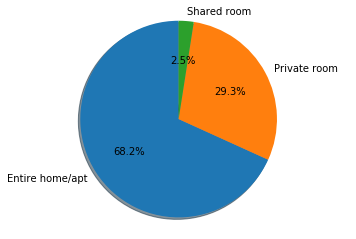

In [110]:
num_entire = np.where(df["room_type"] == "Entire home/apt")[0].size
num_private = np.where(df["room_type"] == "Private room")[0].size
num_shared = np.where(df["room_type"] == "Shared room")[0].size

labels = 'Entire home/apt', 'Private room', 'Shared room'
sizes = [num_entire, num_private, num_shared]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

## Distribution of Cancellation Policy

In [119]:
print(df["cancellation_policy"].unique())
print(df["cancellation_policy"].value_counts())

['strict' 'moderate' 'flexible']
strict      3264
moderate    1887
flexible    1500
Name: cancellation_policy, dtype: int64


(-1.1080416571238416, 1.111956727150845, -1.10732293779438, 1.100348711323542)

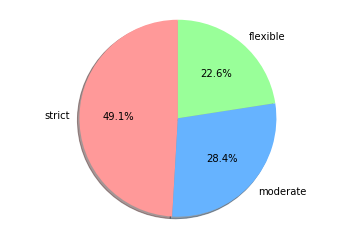

In [123]:
num_strict = np.where(df["cancellation_policy"] == "strict")[0].size
num_moderate = np.where(df["cancellation_policy"] == "moderate")[0].size
num_flexible = np.where(df["cancellation_policy"] == "flexible")[0].size

labels = 'strict', 'moderate', 'flexible'
sizes = [num_strict, num_moderate, num_flexible]

# color scheme from https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=True, startangle=90)
ax.axis('equal')

## Scatterplot of Price vs Number of Reviews

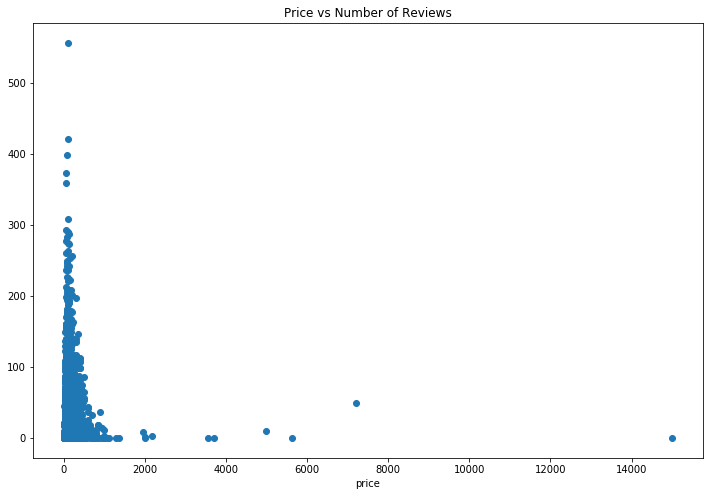

In [116]:
price_review_df = df[["price", "number_of_reviews"]].sort_values(by = "price")

price_review_df.plot(x="price", y="number_of_reviews", style="o", figsize=(12,8), legend=False, title="Price vs Number of Reviews")

From this plot, we see that most listings that cost around \$100 - \$400 get the most ratings. This is most likely due to the fact that people book Airbnb's for short stays so they are relatively cheaper. Also because of this plot, we notice that there are a few outliers. There is an extremely popular listing with over 500 reviews and another listing that costs over \$14,000.

### Data Cleaning (Removing Unnecessary Features)

In [53]:
# Drop features that I believe to be irrelevant

df = df.drop(columns=['id', 'listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'house_rules', 'access',
                      'city', 'state', 'country_code', 'country', 'transit', 'interaction', 'neighbourhood', 'notes',
                      'market', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
                      'smart_location', 'is_location_exact', 'latitude', 'longitude', 'property_type', 'host_name',
                      'host_location', 'host_about', 'host_since', 'host_is_superhost', 'host_response_time', 'zipcode',
                      'street', 'host_response_rate', 'host_listings_count', 'host_total_listings_count',
                      'host_verifications', 'maximum_nights', 'host_identity_verified', 'host_neighbourhood',
                      'host_thumbnail_url', 'host_picture_url', 'has_availability', 'first_review', 'last_review',
                      'instant_bookable', 'host_has_profile_pic', 'calendar_last_scraped', 'calendar_updated',
                      'require_guest_profile_picture', 'requires_license', 'require_guest_phone_verification',
                      'jurisdiction_names', 'license', 'host_acceptance_rate', 'availability_30', 'availability_60',
                      'availability_90', 'availability_365', 'neighbourhood_group_cleansed', 'review_scores_value', 
                      'calculated_host_listings_count', 'weekly_price', 'monthly_price', 'review_scores_accuracy',
                      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                      'review_scores_location', 'reviews_per_month'])

# I removed the weekly_price and montly_price features because most people tend to book for only a few days.

# Removed the has_availability feature since all values were True

# Originally I thought the street feature would be a decent predictor, but it turns out the data only had "Vancouver,
# BC, Canada" as the street value


# I examined the data and realized that only 141 rows of the 6651 have a value for square_feet.
# This corresponds to about only 2% of the data. Some methods that I can use to "fix" this are:
# - predict those values using a form of regression
# - use the mean
# - remove the square_feet feature

# What I will do as a first attempt is simply remove the square_feet feature.
df = df.drop(columns="square_feet")

# Convert bed_type categorical data to numerical data using one-hot encoding
df = pd.get_dummies(df, columns=["bed_type"])

# Convert room_type categorical data to numerical data using one-hot encoding
df = pd.get_dummies(df, columns=["room_type"])

# Convert neighbourhood_cleansed categorical data to numerical data using one-hot encoding
df = pd.get_dummies(df, columns=["neighbourhood_cleansed"])

# Convert is_business_travel_ready categorical data to numerical data using one-hot encoding
df = pd.get_dummies(df, columns=["is_business_travel_ready"])

# Convert cancellation_policy categorical data to numerical data using one-hot encoding
df = pd.get_dummies(df, columns=["cancellation_policy"])

We have gone from starting with 96 features to 23 features. The features that I will be using are:
- name
- summary
- space
- description
- neighborhood_overview
- amenities

- neighbourhood_cleansed
- room_type
- bed_type
- is_business_travel_ready
- cancellation_policy

- accommodates
- bathrooms
- bedrooms
- beds
- price
- security_deposit
- cleaning_fee
- guests_included
- extra_people
- minimum_nights
- number_of_reviews
- review_scores_rating

In [54]:
# Features that will require bag of words / analysis of each word
# - name
# - summary
# - space
# - description
# - neighborhood_overview
# - amenities


# Features that will need to be changed to categorical variables
# x- neighbourhood_cleansed
# x- room_type
# x- bed_type
# x- is_business_travel_ready
# x- cancellation_policy


# Numerical Data
# x- accommodates
# x- bathrooms
# x- bedrooms
# x- beds
# x- price
# x- security_deposit
# x- cleaning_fee
# x- guests_included
# x- extra_people
# x- minimum_nights
# x- number_of_reviews
# x- review_scores_rating

### Normalize Numerical Data

In [55]:
df_numeric = df[["accommodates", "bathrooms", "bedrooms", "beds", "price", "security_deposit", "cleaning_fee",
                 "guests_included", "extra_people", "minimum_nights", "number_of_reviews",
                 "review_scores_rating"]]

# Convert to a matrix in order to use sklearn's normalize
df_numeric_matrix = df_numeric.as_matrix()

# Normalize with sklearn's normalize
matrix_numeric_normalized = normalize(X=df_numeric_matrix, norm='l2')

# Convert back to a Pandas Dataframe
df_numeric_normalized = pd.DataFrame(matrix_numeric_normalized)

# Replace the non-normalized numerical features with normalized features
df[["accommodates", "bathrooms", "bedrooms", "beds", "price", "security_deposit", "cleaning_fee",
    "guests_included", "extra_people", "minimum_nights", "number_of_reviews",
    "review_scores_rating"]] = df_numeric_normalized

In [56]:
# Split dataset into 60-training set 20-validation set and 20-test set approximately
# Let's try to do regression without the bag of words / summary features first
dfY = df["price"]
dfX = df.drop(["price", "name", "summary", "space", "description", "neighborhood_overview", "amenities"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=1)

### Least Squares Linear Regression

In [57]:
# Let's try to do regression without the bag of words / summary features first

# Least squares regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_y_pred = linear_model.predict(X_val)
linear_val_err = np.sum((linear_y_pred - y_val)**2)

Validation error for linear regression is 12.083

### Least Squares Linear Regression with L2 Regularization (Ridge Regression)

In [58]:
# TODO: Do cross-validation
ridge_avg_val_err = 0

for i in np.arange(1,11):
    ridge_model = Ridge(alpha=i)
    ridge_model.fit(X_train, y_train)
    
    ridge_y_pred = ridge_model.predict(X_val)
    ridge_val_err = np.sum((ridge_y_pred - y_val)**2)
    ridge_avg_val_err += ridge_val_err
    
ridge_avg_val_err = ridge_avg_val_err / len(np.arange(1,11))

Validation error using different regularization strengths is 12.931

### Logistic Regression with L1 Regularization

In [59]:
# # TODO: Do cross-validation
# log_reg_avg_val_err = 0

# for i in np.arange(1,11):
#     log_reg_model = LogisticRegression(penalty='l1')
#     log_reg_model.fit(X_train, y_train)
    
#     log_reg_y_pred = log_reg_model.predict(X_val)
#     log_reg_val_err = np.sum((log_reg_y_pred - y_val)**2)
#     log_reg_avg_val_err += log_reg_val_err
    
# log_reg_avg_val_err = log_reg_avg_val_err / len(np.arange(1,11))

TODO: Don't think I should even be using logistic regression at all since I'm doing "regression" and not classification

### Multi-Layer Perceptron Regression

In [60]:
mlp_avg_val_err = 0

for i in np.arange(1,11):
    mlp_model = MLPRegressor(hidden_layer_sizes=(24, 12), activation='relu', learning_rate='adaptive')
    mlp_model.fit(X_train, y_train)

    mlp_y_pred = mlp_model.predict(X_val)
    mlp_val_err = np.sum((mlp_y_pred - y_val)**2)
    mlp_avg_val_err += mlp_val_err

mlp_avg_val_err /= len(np.arange(1,11))

Validation error using two hidden layer of sizes 24 and 12 is 5.396.

### Random Forest Regression

In [61]:
rf_avg_val_err = 0

for i in range(1,11):
    rf_model = RandomForestRegressor(n_estimators=15, criterion='mse', bootstrap=True)
    rf_model.fit(X_train, y_train)
    
    rf_y_pred = rf_model.predict(X_val)
    rf_val_err = np.sum((rf_y_pred - y_val)**2)
    rf_avg_val_err += rf_val_err
    
rf_avg_val_err /= len(np.arange(1,11))

In [62]:
print(rf_avg_val_err)

1.2408745046045389


Validation error using random forest regression with 15 trees is 1.226

Overall, the best model found was using the Random Forest Regression resulting in a validation error of 1.226 averaged over 10 models.

### Feature Selection

Let's try to find the top 5 features that help predict listing price.

In [63]:
# We will use recursive feature elimination for feature selection with the "last" Random Forest model
selector = RFE(estimator=rf_model, n_features_to_select=5, step=1)
selector = selector.fit(X_train, y_train)
print(selector.support_)

[False False False False  True  True False False False  True  True False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]


From the dataset, we see that top 5 predictive features are:
- security_deposit
- cleaning_fee
- extra_people
- number_of_reviews
- review_scores_rating

Interestingly enough, the neighbourhood of a listing doesn't matter as much as the above 5 features. 

# Conclusion